# Car Sales Analysis

## Introduction

In today’s competitive marketplace, businesses must analyze their **sales activities** carefully to maintain profitability and growth.  
This project focuses on analyzing **car product sales** using a **MySQL relational database**, designed specifically for streamlined sales tracking.

The database structure is clean and centered around the core business components:

- **Products**: Items available for sale, such as different car models.
- **Product Lines**: Categories or families of products.
- **Orders**: Customer orders placed for various products.
- **Order Details**: Line items specifying quantities and prices for products in each order.

Unlike the broader ClassicModels example, this setup **excludes** extra layers like customer personal data, employee management, offices, and payments — focusing purely on **sales transactions and inventory**.

---

## Database Structure Overview

| Table Name       | Description                                               |
|------------------|-----------------------------------------------------------|
| `products`       | Catalog of products (e.g., cars, motorcycles, trucks)      |
| `productlines`   | Product categories grouping related products              |
| `orders`         | Records of customer orders (date, status, order number)    |
| `orderdetails`   | Detailed breakdown of each order (product, quantity, price)|

This focused structure allows efficient:

- **Sales performance analysis** 📈
- **Product inventory management** 🛒
- **Category-level (product line) analysis** 🏷️
- **Revenue and profitability reporting** 💰

---

## Why MySQL for Car Sales Analysis?

- **Simplicity**: Relational structure is easy to navigate and maintain.
- **Speed**: Quick retrieval of important KPIs (Key Performance Indicators).
- **Expandability**: Easily add more entities (like customers or employees) later.
- **Real-World Simulation**: Ideal training for managing real automotive sales data.

---

## Entity-Relationship Diagram (ERD) Overview

The ERD below shows the structure of the car sales database.  
It includes four main tables: **Products**, **Product Lines**, **Orders**, and **Order Details**.

- Each **Product** belongs to a **Product Line**.
- Each **Order** can include multiple **Order Details**.
- Each **Order Detail** links an **Order** to a **Product**.

This design helps track product categories, sales transactions, and revenue efficiently.

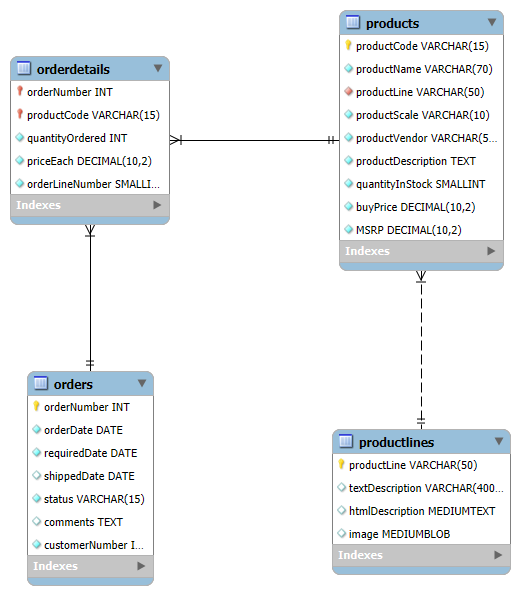

---

## Code

In [14]:
import mysql.connector
import pandas as pd

# ================================
# 🔍 Database Setup
# ================================

# Establish a connection to the MySQL database
connection = mysql.connector.connect(
    host='localhost',  # Replace with your host
    user='root',  # Replace with your username
    password='haikal98',  # Replace with your password
    database='classicmodels_new'  # Switch to the desired database
)

In [16]:
# Create a cursor object to execute SQL queries
cursor = connection.cursor()

# Display the existing databases
cursor.execute("SHOW DATABASES;")
databases = cursor.fetchall()
print("Databases:")
for db in databases:
    print(db[0])

# Show all tables in the current database
cursor.execute("SHOW TABLES;")
tables = cursor.fetchall()
print("\nTables:")
for table in tables:
    print(table[0])

# Describe specific tables to understand their structure
tables_to_describe = ['orderdetails', 'orders', 'productlines', 'products']
for table in tables_to_describe:
    cursor.execute(f"DESCRIBE {table};")
    description = cursor.fetchall()
    
    # Create a DataFrame from the description
    description_df = pd.DataFrame(description, columns=['Field', 'Type', 'Null', 'Key', 'Default', 'Extra'])
    
    print(f"\nStructure of {table}:")
    print(description_df)

# ================================
# 🔧 STORED PROCEDURES
# ================================

# 1. Get Order Details by Order Number
def get_order_details(order_number):
    query = """
    SELECT 
        o.orderNumber,
        o.orderDate,
        p.productName,
        od.quantityOrdered,
        od.priceEach,
        (od.quantityOrdered * od.priceEach) AS lineTotal
    FROM 
        orders o
    JOIN 
        orderdetails od ON o.orderNumber = od.orderNumber
    JOIN 
        products p ON od.productCode = p.productCode
    WHERE 
        o.orderNumber = %s;
    """
    cursor.execute(query, (order_number,))
    return cursor.fetchall()

# Call the stored procedure with an example order number
order_details = get_order_details(10165)
print("\nOrder Details for Order Number 10165:")
order_details_df = pd.DataFrame(order_details, columns=['Order Number', 'Order Date', 'Product Name', 'Quantity Ordered', 'Price Each', 'Line Total'])
print(order_details_df)

# 2. Get Products Below a Certain Stock Level
def get_low_stock_products(stock_threshold):
    query = """
    SELECT 
        productCode,
        productName,
        quantityInStock
    FROM 
        products
    WHERE 
        quantityInStock < %s;
    """
    cursor.execute(query, (stock_threshold,))
    return cursor.fetchall()

# Call the function to see products with low stock
low_stock_products = get_low_stock_products(250)
print("\nLow Stock Products:")
low_stock_products_df = pd.DataFrame(low_stock_products, columns=['Product Code', 'Product Name', 'Quantity In Stock'])
print(low_stock_products_df)

# ================================
# 👁️ VIEWS
# ================================

# 3. Orders Revenue View
cursor.execute("""
CREATE OR REPLACE VIEW view_orders_revenue AS
SELECT 
    o.orderNumber,
    o.orderDate,
    SUM(od.quantityOrdered * od.priceEach) AS totalOrderRevenue
FROM 
    orders o
JOIN 
    orderdetails od ON o.orderNumber = od.orderNumber
GROUP BY 
    o.orderNumber;
""")

# 4. Product Inventory View
cursor.execute("""
CREATE OR REPLACE VIEW view_product_inventory AS
SELECT 
    productCode,
    productName,
    quantityInStock,
    buyPrice,
    MSRP
FROM 
    products;
""")

# Show all views
cursor.execute("SHOW FULL TABLES WHERE table_type = 'VIEW';")
views = cursor.fetchall()
print("\nViews:")
for view in views:
    print(view[0])

# Display the contents of the views
cursor.execute("SELECT * FROM view_orders_revenue;")
orders_revenue = cursor.fetchall()
print("\nOrders Revenue View:")
orders_revenue_df = pd.DataFrame(orders_revenue, columns=['Order Number', 'Order Date', 'Total Order Revenue'])
print(orders_revenue_df)

cursor.execute("SELECT * FROM view_product_inventory;")
product_inventory = cursor.fetchall()
print("\nProduct Inventory View:")
product_inventory_df = pd.DataFrame(product_inventory, columns=['Product Code', 'Product Name', 'Quantity In Stock ', 'Buy Price', 'MSRP'])
print(product_inventory_df)

# ================================
# 💡 USEFUL MYSQL QUERIES
# ================================

# 6. Join Orders and Order Details
cursor.execute("""
SELECT 
    orders.orderNumber, 
    orders.orderDate, 
    orderdetails.productCode, 
    orderdetails.quantityOrdered, 
    orderdetails.priceEach
FROM orders
JOIN orderdetails ON orders.orderNumber = orderdetails.orderNumber;
""")
joined_orders_details = cursor.fetchall()
print("\nJoined Orders and Order Details:")
joined_orders_details_df = pd.DataFrame(joined_orders_details, columns=['Order Number', 'Order Date', 'Product Code', 'Quantity Ordered', 'Price Each'])
print(joined_orders_details_df)

# 7. Join Products with Product Lines
cursor.execute("""
SELECT p.productCode, p.productName, pl.productLine
FROM products p
JOIN productlines pl ON p.productLine = pl.productLine;
""")
joined_products_lines = cursor.fetchall()
print("\nJoined Products with Product Lines:")
joined_products_lines_df = pd.DataFrame(joined_products_lines, columns=['Product Code', 'Product Name', 'Product Line'])
print(joined_products_lines_df)

# 8. Total Revenue per Order
cursor.execute("""
SELECT 
    orderdetails.orderNumber, 
    SUM(orderdetails.quantityOrdered * orderdetails.priceEach) AS totalRevenue
FROM orderdetails
GROUP BY orderdetails.orderNumber;
""")
total_revenue_per_order = cursor.fetchall()
print("\nTotal Revenue per Order:")
total_revenue_per_order_df = pd.DataFrame(total_revenue_per_order, columns=['Order Number', 'Total Revenue'])
print(total_revenue_per_order_df)

# 9. Orders That Have Not Been Shipped
cursor.execute("SELECT * FROM orders WHERE shippedDate IS NULL;")
unshipped_orders = cursor.fetchall()
print("\nOrders That Have Not Been Shipped:")

# Adjust the column names based on the actual structure of the orders table
unshipped_orders_df = pd.DataFrame(unshipped_orders, columns=['Order Number', 'Order Date', 'Required Date', 'Shipped Date', 'Status', 'Customer Number', 'Other Column 1'])
print(unshipped_orders_df)

# 10. Orders Within a Specific Date Range
cursor.execute("""
SELECT orderNumber, orderDate, status
FROM orders
WHERE orderDate BETWEEN '2003-01-01' AND '2004-04-26';
""")
orders_in_date_range = cursor.fetchall()
print("\nOrders Within a Specific Date Range:")
orders_in_date_range_df = pd.DataFrame(orders_in_date_range, columns=['Order Number', 'Order Date', 'Status'])
print(orders_in_date_range_df)

# 11. Basic Product Information
cursor.execute("""
SELECT productCode, productName, quantityInStock, MSRP
FROM products;
""")
basic_product_info = cursor.fetchall()
print("\nBasic Product Information:")
basic_product_info_df = pd.DataFrame(basic_product_info, columns=['Product Code', 'Product Name', 'Quantity In Stock', 'MSRP'])
print(basic_product_info_df)

# 12. Product Line Information
cursor.execute("""
SELECT productLine, textDescription
FROM productlines;
""")
product_line_info = cursor.fetchall()
print("\nProduct Line Information:")
product_line_info_df = pd.DataFrame(product_line_info, columns=['Product Line', 'Description'])
print(product_line_info_df)

# 13. Top 5 Best-Selling Products
cursor.execute("""
SELECT 
    p.productName,
    SUM(od.quantityOrdered) AS totalSold
FROM 
    products p
JOIN 
    orderdetails od ON p.productCode = od.productCode
GROUP BY 
    p.productName
ORDER BY 
    totalSold DESC
LIMIT 5;
""")
top_selling_products = cursor.fetchall()
print("\nTop 5 Best-Selling Products:")
top_selling_products_df = pd.DataFrame(top_selling_products, columns=['Product Name', 'Total Sold'])
print(top_selling_products_df)

# 14. Average Quantity Sold of Each Product
cursor.execute("""
SELECT p.productCode, p.productName, AVG(od.quantityOrdered) AS avgQuantity
FROM products p
JOIN orderdetails od ON p.productCode = od.productCode
GROUP BY p.productCode, p.productName;
""")
average_quantity_sold = cursor.fetchall()
print("\nAverage Quantity Sold of Each Product:")
average_quantity_sold_df = pd.DataFrame(average_quantity_sold, columns=['Product Code', 'Product Name', 'Average Quantity'])
print(average_quantity_sold_df)

# 15. Late Shipped Orders
cursor.execute("""
SELECT 
    orderNumber,
    orderDate,
    requiredDate,
    shippedDate
FROM 
    orders
WHERE 
    shippedDate > requiredDate
ORDER BY 
    shippedDate;
""")
late_shipped_orders = cursor.fetchall()
print("\nLate Shipped Orders:")
late_shipped_orders_df = pd.DataFrame(late_shipped_orders, columns=['Order Number', 'Order Date', 'Required Date', 'Shipped Date'])
print(late_shipped_orders_df)

# 16. Monthly Sales Revenue
cursor.execute("""
SELECT 
    DATE_FORMAT(o.orderDate, '%Y-%m') AS orderMonth,
    SUM(od.quantityOrdered * od.priceEach) AS totalRevenue
FROM 
    orders o
JOIN 
    orderdetails od ON o.orderNumber = od.orderNumber
GROUP BY 
    orderMonth
ORDER BY 
    orderMonth;
""")
monthly_sales_revenue = cursor.fetchall()
print("\nMonthly Sales Revenue:")
monthly_sales_revenue_df = pd.DataFrame(monthly_sales_revenue, columns=['Order Month', 'Total Revenue'])
print(monthly_sales_revenue_df)

# 17. Product Line Info with Descriptions
cursor.execute("""
SELECT 
    p.productCode,
    p.productName,
    pl.textDescription
FROM 
    products p
LEFT JOIN 
    productlines pl ON p.productLine = pl.productLine
ORDER BY 
    p.productName;
""")
product_line_descriptions = cursor.fetchall()
print("\nProduct Line Info with Descriptions:")
product_line_descriptions_df = pd.DataFrame(product_line_descriptions, columns=['Product Code', 'Product Name', 'Description'])
print(product_line_descriptions_df)

# 18. Products That Have Never Been Ordered
cursor.execute("""
SELECT 
    p.productCode,
    p.productName
FROM 
    products p
LEFT JOIN 
    orderdetails od ON p.productCode = od.productCode
WHERE 
    od.orderNumber IS NULL;
""")
never_ordered_products = cursor.fetchall()
print("\nProducts That Have Never Been Ordered:")
never_ordered_products_df = pd.DataFrame(never_ordered_products, columns=['Product Code', 'Product Name'])
print(never_ordered_products_df)

# 19. Average Order Value Calculation
cursor.execute("""
SELECT 
    AVG(orderRevenue) AS averageOrderValue
FROM (
    SELECT 
        o.orderNumber,
        SUM(od.quantityOrdered * od.priceEach) AS orderRevenue
    FROM 
        orders o
    JOIN 
        orderdetails od ON o.orderNumber = od.orderNumber
    GROUP BY 
        o.orderNumber
) AS revenue_per_order;
""")
average_order_value = cursor.fetchone()
print("\nAverage Order Value:")
average_order_value_df = pd.DataFrame([average_order_value], columns=['Average Order Value'])
print(average_order_value_df)

# 20. Count Orders by Status
cursor.execute("""
SELECT 
    status,
    COUNT(*) AS numberOfOrders
FROM 
    orders
GROUP BY 
    status;
""")
orders_count_by_status = cursor.fetchall()
print("\nCount of Orders by Status:")
orders_count_by_status_df = pd.DataFrame(orders_count_by_status, columns=['Status', 'Number of Orders'])
print(orders_count_by_status_df)

# 21. Identify Product Line with Most Products
cursor.execute("""
SELECT 
    productLine,
    COUNT(*) AS totalProducts
FROM 
    products
GROUP BY 
    productLine
ORDER BY 
    totalProducts DESC
LIMIT 1;
""")
most_products_line = cursor.fetchone()
print("\nProduct Line with Most Products:")
most_products_line_df = pd.DataFrame([most_products_line], columns=['Product Line', 'Total Products'])
print(most_products_line_df)

# 22. Revenue by Product Line
cursor.execute("""
SELECT 
    pl.productLine,
    SUM(od.quantityOrdered * od.priceEach) AS totalRevenue
FROM 
    productlines pl
JOIN 
    products p ON pl.productLine = p.productLine
JOIN 
    orderdetails od ON p.productCode = od.productCode
GROUP BY 
    pl.productLine
ORDER BY 
    totalRevenue DESC;
""")
revenue_by_product_line = cursor.fetchall()
print("\nRevenue by Product Line:")
revenue_by_product_line_df = pd.DataFrame(revenue_by_product_line, columns=['Product Line', 'Total Revenue'])
print(revenue_by_product_line_df)

# 23. Products with Low Sales Volume
cursor.execute("""
SELECT 
    p.productName,
    SUM(od.quantityOrdered) AS totalSold
FROM 
    products p
LEFT JOIN 
    orderdetails od ON p.productCode = od.productCode
GROUP BY 
    p.productName
HAVING 
    totalSold < 1500;
""")
low_sales_volume_products = cursor.fetchall()
print("\nProducts with Low Sales Volume:")
low_sales_volume_products_df = pd.DataFrame(low_sales_volume_products, columns=['Product Name', 'Total Sold'])
print(low_sales_volume_products_df)

# 24. Year-Over-Year Sales Growth
cursor.execute("""
SELECT 
    YEAR(o.orderDate) AS salesYear,
    SUM(od.quantityOrdered * od.priceEach) AS totalSales
FROM 
    orders o
JOIN 
    orderdetails od ON o.orderNumber = od.orderNumber
GROUP BY 
    salesYear
ORDER BY 
    salesYear;
""")
year_over_year_sales_growth = cursor.fetchall()
print("\nYear-Over-Year Sales Growth:")
year_over_year_sales_growth_df = pd.DataFrame(year_over_year_sales_growth, columns=['Sales Year', 'Total Sales'])
print(year_over_year_sales_growth_df)

# 25. Top Products by Revenue Contribution
cursor.execute("""
SELECT 
    p.productName,
    SUM(od.quantityOrdered * od.priceEach) AS totalProductRevenue
FROM 
    products p
JOIN 
    orderdetails od ON p.productCode = od.productCode
GROUP BY 
    p.productName
ORDER BY 
    totalProductRevenue DESC
LIMIT 10;
""")
top_products_revenue = cursor.fetchall()
print("\nTop Products by Revenue Contribution:")
top_products_revenue_df = pd.DataFrame(top_products_revenue, columns=['Product Name', 'Total Product Revenue'])
print(top_products_revenue_df)

# Close the cursor and connection
cursor.close()
connection.close()

Databases:
classicmodels
classicmodels_new
information_schema
mydb
mysql
mysql_python
performance_schema
sales
sql_intro
sql_iq
sql_joins
sys
test
triggers
world

Tables:
orderdetails
orders
productlines
products

Structure of orderdetails:
             Field           Type Null  Key Default Extra
0      orderNumber            int   NO  PRI    None      
1      productCode    varchar(15)   NO  PRI    None      
2  quantityOrdered            int   NO         None      
3        priceEach  decimal(10,2)   NO         None      
4  orderLineNumber       smallint   NO         None      

Structure of orders:
            Field         Type Null  Key Default Extra
0     orderNumber          int   NO  PRI    None      
1       orderDate         date   NO         None      
2    requiredDate         date   NO         None      
3     shippedDate         date  YES         None      
4          status  varchar(15)   NO         None      
5        comments         text  YES         None      
6  c

## Reference

1. prof3ssorSt3v3. (n.d.). *ClassicModels Database Schema* [SQL script]. GitHub Gist. Retrieved July 15, 2024, from https://gist.github.com/prof3ssorSt3v3/796ebc82fd8eeb0b697effaa1e86c3a6  

In [15]:
!jupyter nbconvert  car_sales.ipynb --to webpdf

[NbConvertApp] Converting notebook car_sales.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 270565 bytes to car_sales.pdf
